# Notebook Title

Last modified: 

**Executive summary:**  

Because the target variable does not distingusih between prediabetes and diabetes, people with prediabetes and people with diabetes are both addressed as people with diabetes throughought this notebook

-----

Cite this CDC article: https://www.cdc.gov/diabetes/php/data-research/index.html

Load necessary variables:

Requirements:  
- pandas 2.2.3
- matplotlib 3.10.1
- seaborn 0.13.2
- scikit-learn 1.6.1
- humanfriendly 10.0

Optional but recommended:
- tqdm 4.66.4
- ipywidgets 8.1.6

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import humanfriendly as hf
from copy import copy
import numpy as np

# sns.set_theme(rc={"figure.dpi": 150},style='white')

# import warnings
# warnings.filterwarnings('ignore')

import os

def EJrename(src,dst):
    try:
        os.rename(src, dst)
    except FileExistsError:
        os.remove(dst)
        os.rename(src, dst)


## Step 1: Data Preprocessing

Load data and perform checks

In [3]:
df = pd.read_csv('raw_data/diabetes_binary_health_indicators_BRFSS2015.csv')
y = df['Diabetes_binary']
df = df.drop('Diabetes_binary',axis=1)
df.head(2)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0


In [4]:
#Check for NaNs
print(f'There are {df.isna().sum().sum()} NaNs in the dataset')
print(f'There are {y.isna().sum()} NaNs in the target variable')

#Is the dataset well balanced?
print(f'There are {hf.format_number(int(y.sum()))} people with diabetes in the dataset, {100*y.sum()/len(y):.2f}% of the {hf.format_number(len(y))} samples.')

There are 0 NaNs in the dataset
There are 0 NaNs in the target variable
There are 35,346 people with diabetes in the dataset, 13.93% of the 253,680 samples.


# Something to consider:

According to the CDC, just over 40% of all US population have either diabetes (11.6%) or prediabetes (29.5%)* . This is not only a stagering number, but it means that our database contains much fewer positives than our target population.

I will separate 10% of the total positives in the original dataset while keeping a target potive ratio of 40% in that validation cohort. Similarly, whenever k-fold validation is performed, a this positive rate of 40% will be maintained by using [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) from `sklearn`.

*In millions: 38.4 persons with diabetes and 97.6 adults with prediabetes out of an estimated 331 persons in the U.S. [source](https://www.cdc.gov/diabetes/php/data-research/index.html): https://www.cdc.gov/diabetes/php/data-research/index.html


# ---> Conclussion. For now I will keep the 86/14 ratio, to not unnecesarily drop true negative samples (which are important). But this is something to be discussed.


## Step 2: Exploratory Data Analysis

### Features' values distriutions

In [193]:
def plot_histograms(to_plot,title='Histogram Per Feature\nDiabetes and No-Diabetes Populations Normalized Separately',col='Diabetes',tight=True):
    fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(14, 8),sharey=True)
    # Flatten the axes array (makes it easier to iterate over)
    axes = axes.flatten()

    # Loop through each column and plot a histogram
    for i, column in enumerate(df.columns):
        if column==col: continue
        ax = sns.histplot(data=to_plot[[column,col]],hue=col,x=column,stat="percent",
                        common_norm=False,bins=10,multiple="dodge",ax=axes[i], edgecolor='white',)
        axes[i].set_xlabel(column) 
        axes[i].set_ylabel('Percent')
        
        # Use only one legend for the whole plot
        if i== 0:
            plot_legend = axes[i].get_legend()
            sns.move_legend(ax, "lower left",bbox_to_anchor=(0, 1.2), title=col, ncol=2)
        else:
            axes[i].get_legend().remove() #remove the redundant legend

    if tight:
        plt.tight_layout()
    else:
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.suptitle(title,y=0.95)
    plt.show()

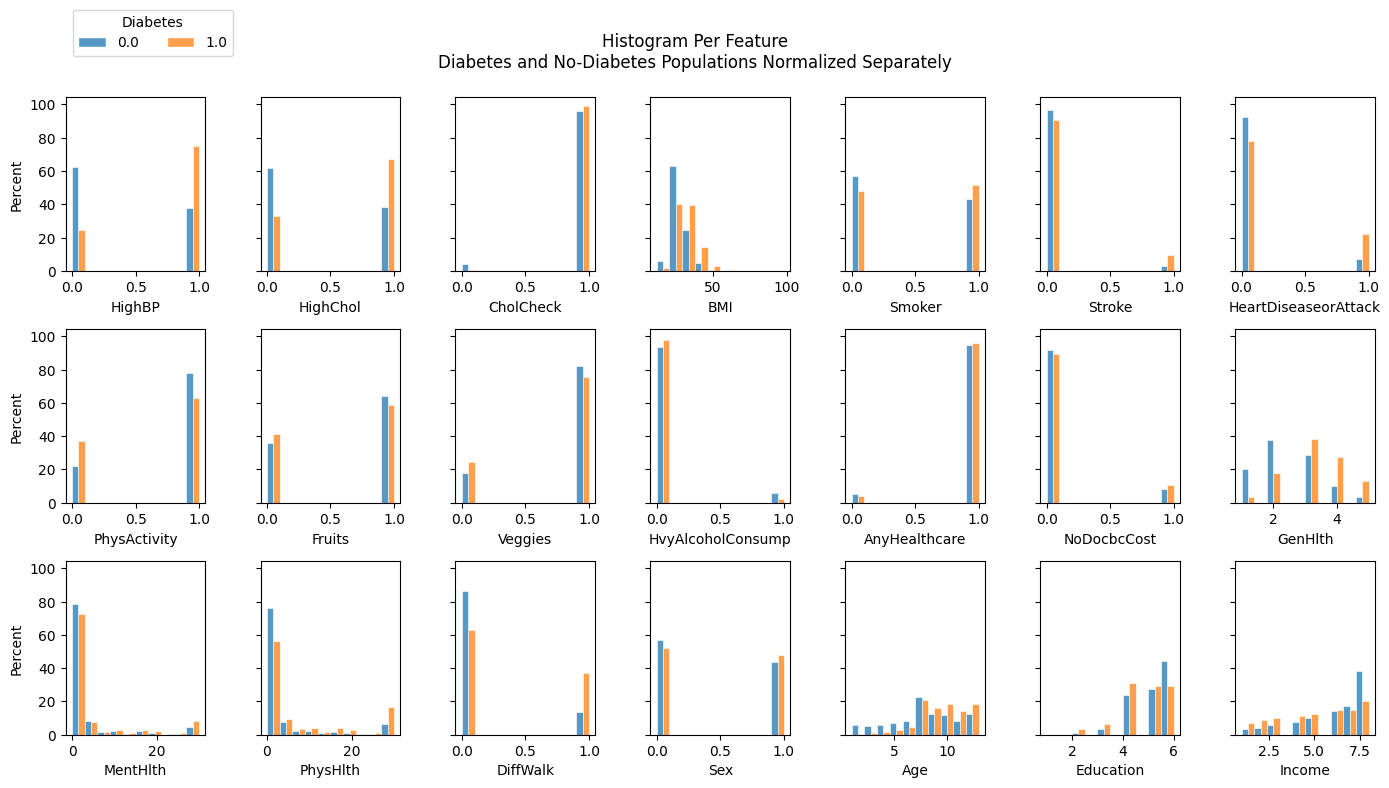

In [195]:
to_plot = df.copy()
to_plot['Diabetes'] = y

plot_histograms(to_plot=to_plot)

Note: Age is an ordinal variable that maps to the real age of the person as described in [this notebook](https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook): "1 is 18-24 all the way up to 13 wis 80 and older. 5 year increments. [Removed] 14 because it is don't know or missing"

# --> Same with Education, Income, etc

### Looking into feature correlations

In [7]:
# to_plot.corr()

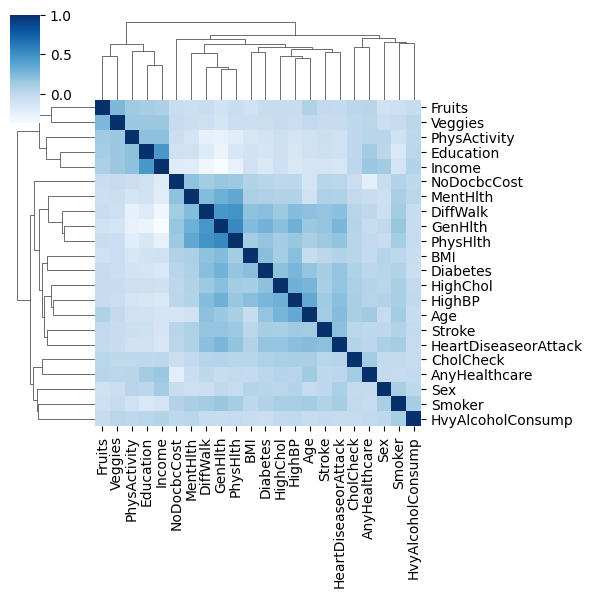

In [8]:
# sns.heatmap(data=to_plot.corr(),cmap='Blues')
sns.clustermap(data=to_plot.corr(),cmap='Blues',figsize=(6,6))

There are some slighlty correlated variables, e.g., Geneneral Health with Physical Health ($\rho$=0.52), and Difficulty walking ($\rho$=0.46). But no two variables are higly correlated, i.e., the max correlation is 0.52.

General Health is also the feature that has the highest correlation with the target variable $\rho$=0.29.

## Step 3: Model Selection

### Creating a validation set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.1, random_state=42,stratify=y)

### Initial Model Fit 

In [66]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

In [96]:
# train_and_predict(df.fillna(0),y,all_regs['L2Regression'],df.fillna(0).head())

def train_and_predict(X_train,y_train,model,X_test=None,y_test=None,folds=1,make_ROC_plots=True,ax=None):
    if folds==1:
        X_test = X_test[X_train.columns] # Just making sure the columns are in the same order
        model = model.fit(X_train,y_train)
        if X_test is None:
            print('WARNING: No predictions')
            return model,None,None,None,None,None

        y_pred = model.predict(X_test)
        # y_probs = model.predict_proba(X_test)
        # cm = confusion_matrix(y_test, y_pred)
        # tn, fp, fn, tp = cm.ravel()

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        p,r,f,_ = precision_recall_fscore_support(y_test,y_pred,average='binary',pos_label=1)
        if make_ROC_plots:
            if ax is None:
                ax = fig, ax = plt.subplots()
            curve = RocCurveDisplay.from_predictions(y_test, y_pred,ax=ax,label=f'{auc:.2f}')
            ax.set_title(str(model).split('(')[0])
            ax.legend(title="AUC",fancybox=True,loc=4,markerscale=0.5)
            ax.set_ylabel('')
            ax.set_xlabel('')
        return model,y_pred,auc,p,r,f

    else:
        #performing k-fold validation

        # K-fold cross-validation
        kf = StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)

        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_scores = []
        
        if make_ROC_plots:
            if ax is None:
                ax = fig, ax = plt.subplots()


        for train_index, test_index in kf.split(X_train,y_train):
            currX_train = X_train.iloc[train_index]
            currX_test = X_train.iloc[test_index]
            curry_train, curry_test = y_train.iloc[train_index], y_train.iloc[test_index]
            
            model.fit(currX_train, curry_train)
            y_pred = model.predict(currX_test)

            fpr, tpr, thresholds = metrics.roc_curve(curry_test, y_pred, pos_label=1)
            auc = metrics.auc(fpr, tpr)

            p,r,f,_ = precision_recall_fscore_support(curry_test,y_pred,average='binary',pos_label=1)
            
            precision_scores.append(p)
            recall_scores.append(r)
            f1_scores.append(f)
            auc_scores.append(auc)
            if make_ROC_plots:
                auc_disp = RocCurveDisplay.from_predictions(curry_test, y_pred,ax=ax,label=f'{auc:.2f}')
                ax.set_title(str(model).split('(')[0])
                ax.legend(title="AUC",fancybox=True,loc=4,markerscale=0.5)
                ax.set_ylabel('')
                ax.set_xlabel('')

        #These values won't make sense if we return them.
        model = None
        y_pred = None

        return model,y_pred,auc_scores,precision_scores,recall_scores,f1_scores

In [11]:
# train_and_predict(X_train,y_train,all_class['CategoricalNB'],X_test=None,y_test=None,folds=5,make_ROC_plots=True,ax=None)

Sice the data consist of both binary data and some categorial variables. The following classifiers have been chosen for the first round of model fit:


Other models' assumptions are not met, and these ones represent a wide selection of models.

In [15]:
# These next three lines are lefover from a "round 0" where I blindly tried all estimators to confirm that the ones that are theoretically solid produce the best results
# from sklearn.utils import all_estimators
# estimators = all_estimators(type_filter='classifier')
# estimators = all_estimators()

from sklearn.naive_bayes import CategoricalNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

all_class = {} #dictionary to store all classifiers
#3 Versions of Naive Bayes
all_class['CategoricalNB']= CategoricalNB()
all_class['BernoulliNB']= BernoulliNB()
all_class['GaussianNB']= GaussianNB() #Data does not look strictly gaussian, but sometimes it's an acceptable approximation
#Logistic regression
all_class['LogisticRegression']=LogisticRegression(random_state=42,max_iter=1000)
# Boundary-based/discriminant methods
all_class['LinearDiscriminantAnalysis'] = LinearDiscriminantAnalysis()
all_class['QuadraticDiscriminantAnalysis'] = QuadraticDiscriminantAnalysis()
# Distance/Neighbors-based methods
all_class['KNeighborsClassifier'] = KNeighborsClassifier()
all_class['NearestCentroid'] = NearestCentroid()
#Ensemble classifiers
all_class['AdaBoostClassifier'] = AdaBoostClassifier(random_state=42)
all_class['HistGradientBoostingClassifier'] = HistGradientBoostingClassifier(random_state=42) # faster than GradientBoostingClassifier
all_class['RandomForestClassifier'] = RandomForestClassifier(random_state=42)
#Finally adding a Neural-Network approach to cover all the bases
all_class['MLPClassifier'] = MLPClassifier(random_state=42,max_iter=1000)



In [61]:
from IPython.display import clear_output
def train_and_predict_all_models(all_classifiers,X_train,y_train,X_test=None,y_test=None,folds=1,make_ROC_plots=True):
    trained_models ={}
    elapsed = None
    out = pd.DataFrame()
    if make_ROC_plots:
        n_plots = len(all_classifiers)
        # I know there are 12 classifiers in the first round, but this should make it a bit more generalizible
        cols = 3  
        rows = (n_plots + cols - 1) // cols
        fig, axs = plt.subplots(nrows=rows, ncols=cols,figsize=(cols*3,rows*3),dpi=96,sharex=True,sharey=True)
        axs = axs.flatten()
    i = 0
    for name,model in (pbar:=tqdm(zip(all_classifiers.keys(),all_classifiers.values()),total=len(all_classifiers))):
        start_time = time.time()
        pbar.set_description(f'{name} | previous run: {elapsed}')
        if X_test is None:
            model,y_pred,auc,p,r,f = train_and_predict(X_train=X_train,y_train=y_train,model=model,X_test=X_train,y_test=y_train,
                                                       folds=folds,make_ROC_plots=make_ROC_plots,ax=axs[i])
        else:
            model,y_pred,auc,p,r,f = train_and_predict(X_train=X_train,y_train=y_train,model=model,X_test=X_test,y_test=y_test,
                                                       folds=folds,make_ROC_plots=make_ROC_plots,ax=axs[i])
        elapsed = hf.format_timespan(time.time()-start_time)

        trained_models[name] = copy(model)
        out.loc[i,'Name'] = name
        out.loc[i,'avg AUC'] = np.mean(auc)
        out.loc[i,'med AUC'] = np.median(auc)
        out.loc[i,'std AUC'] = np.std(auc)
        out.loc[i,'avg Precision'] = np.mean(p)
        out.loc[i,'med Precision'] = np.median(p)
        out.loc[i,'std Precision'] = np.std(p)
        out.loc[i,'avg Recall'] = np.mean(r)
        out.loc[i,'med Recall'] = np.median(r)
        out.loc[i,'std Recall'] = np.std(r)
        out.loc[i,'avg F1'] = np.mean(f)
        out.loc[i,'med F1'] = np.median(f)
        out.loc[i,'std F1'] = np.std(f)
        out.loc[i,'Elapsed'] = elapsed
        # print(name,f"mean auc={np.mean(auc):.2f}(\u03C3={np.std(auc):.2f})",f"mean p={np.mean(p):.2f}(\u03C3={np.std(p):.2f})",
            #   f"mean r={np.mean(r):.2f}(\u03C3={np.std(r):.2f})",f"mean f={np.mean(f):.2f}(\u03C3={np.std(f):.2f})",
            #   f"|{elapsed}")
        clear_output()  # Clear previous output
        display(pbar.container)
        display(out)
        if make_ROC_plots:
            display(fig)
        i+=1
    clear_output(wait=True)  # Clear previous output
    display(out)
    display(pbar.container)
    # if make_ROC_plots:
        # display(fig)
    return out,trained_models

"Breath-first" approach. Testing many classifiers with default parametners:

,Name,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1,Elapsed
0,CategoricalNB,0.687096,0.686788,0.001097,0.378241,0.378244,0.001626,0.509887,0.509274,0.003249,0.434298,0.433561,0.001236,0.51 seconds
1,BernoulliNB,0.623452,0.623932,0.001379,0.391581,0.389834,0.002961,0.329886,0.330871,0.003015,0.358087,0.358444,0.002464,0.48 seconds
2,GaussianNB,0.688615,0.688967,0.003025,0.323458,0.323965,0.001856,0.570338,0.570732,0.006772,0.412798,0.413318,0.003238,0.49 seconds
3,LogisticRegression,0.567644,0.568163,0.002090,0.536653,0.536639,0.011100,0.157273,0.159227,0.003956,0.243244,0.244834,0.005632,17.66 seconds
4,LinearDiscriminantAnalysis,0.587247,0.587980,0.002426,0.510303,0.508100,0.010305,0.206595,0.207796,0.004575,0.294100,0.295770,0.005919,1.13 seconds
5,QuadraticDiscriminantAnalysis,0.680712,0.680481,0.002335,0.315891,0.315635,0.001628,0.556537,0.557058,0.005322,0.403021,0.403158,0.002542,1 second
6,KNeighborsClassifier,0.572525,0.572474,0.001584,0.398602,0.401608,0.006569,0.191946,0.192707,0.003211,0.259097,0.259150,0.003702,27.47 seconds
7,NearestCentroid,0.640199,0.640600,0.001938,0.276483,0.277131,0.002589,0.486530,0.488135,0.003856,0.352586,0.352160,0.002561,0.49 seconds
8,AdaBoostClassifier,0.577778,0.577547,0.001010,0.538279,0.538028,0.008940,0.180661,0.180132,0.002310,0.270499,0.269901,0.002610,16.66 seconds
9,HistGradientBoostingClassifier,0.570720,0.571285,0.001910,0.584328,0.584597,0.011752,0.159882,0.160484,0.004718,0.250989,0.252504,0.005403,5.23 seconds


MLPClassifier | previous run: 1 minute and 0.39 seconds: 100%|##########| 12/12 [07:59<00:00, 122.03s/it]

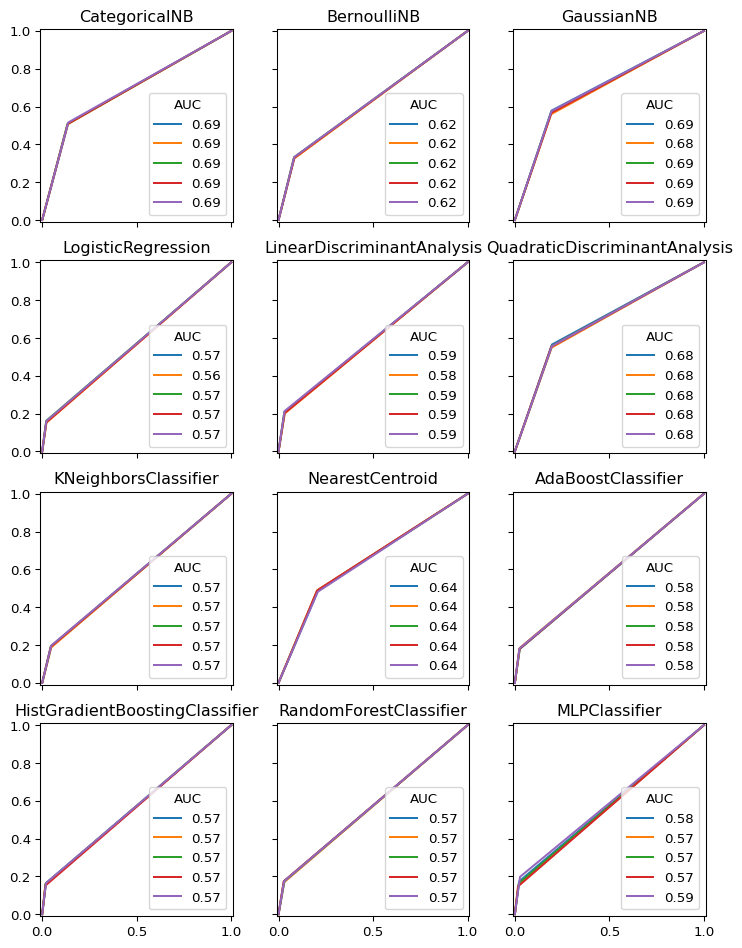

In [14]:
defaults_df, default_trained_models = train_and_predict_all_models(all_class,X_train,y_train,folds=5)

Because this is an early screening tool *recall* is an important metric. Recall ($\frac{TP}{TP+FN}$*) is also known as the true positive rate, meaning this is the proportion of all positve (diabetes) samples that are found by our classifier. This value is important because an early screening tool should aim to find as many true positives as possible.

However, perfect recall could be achieved by simply flagging every patient as "1" for diabetes. So we must also consider the *precision* of the model (the proportion of the patients predicted to have diabetes by the model who actually have diabetes, $\frac{TP}{TP+FP}$*).

To balance these two we will focus on the *F1* score, which is the harmonic mean of precision and recall and the rea Under the Receiver Operating Characteristic curve (AUC-ROC, or AUC for short). However, we will keep an eye on recall as a way to decide between different models with similar F1 scores.

*TP: True positive, FN: False negative, FP: False positive.

In [15]:
defaults_df.sort_values(by='avg F1',ascending=False)

,Name,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1,Elapsed
0,CategoricalNB,0.687096,0.686788,0.001097,0.378241,0.378244,0.001626,0.509887,0.509274,0.003249,0.434298,0.433561,0.001236,0.51 seconds
2,GaussianNB,0.688615,0.688967,0.003025,0.323458,0.323965,0.001856,0.570338,0.570732,0.006772,0.412798,0.413318,0.003238,0.49 seconds
5,QuadraticDiscriminantAnalysis,0.680712,0.680481,0.002335,0.315891,0.315635,0.001628,0.556537,0.557058,0.005322,0.403021,0.403158,0.002542,1 second
1,BernoulliNB,0.623452,0.623932,0.001379,0.391581,0.389834,0.002961,0.329886,0.330871,0.003015,0.358087,0.358444,0.002464,0.48 seconds
7,NearestCentroid,0.640199,0.640600,0.001938,0.276483,0.277131,0.002589,0.486530,0.488135,0.003856,0.352586,0.352160,0.002561,0.49 seconds
4,LinearDiscriminantAnalysis,0.587247,0.587980,0.002426,0.510303,0.508100,0.010305,0.206595,0.207796,0.004575,0.294100,0.295770,0.005919,1.13 seconds
8,AdaBoostClassifier,0.577778,0.577547,0.001010,0.538279,0.538028,0.008940,0.180661,0.180132,0.002310,0.270499,0.269901,0.002610,16.66 seconds
6,KNeighborsClassifier,0.572525,0.572474,0.001584,0.398602,0.401608,0.006569,0.191946,0.192707,0.003211,0.259097,0.259150,0.003702,27.47 seconds
11,MLPClassifier,0.572692,0.571056,0.007138,0.561598,0.556568,0.017903,0.166641,0.163156,0.017997,0.256168,0.252340,0.019255,5 minutes and 43.02 seconds
10,RandomForestClassifier,0.571875,0.572391,0.001194,0.489276,0.490608,0.011442,0.173022,0.173530,0.002640,0.255598,0.256887,0.003064,1 minute and 0.39 seconds


Based on this, and in order to keep a selection of models the following models will be used during hyperparameter tuning:
- CategoricalNB
- QuadraticDiscriminantAnalysis
- NearestCentroid
- AdaBoostClassifier
- RandomForestClassifier
- LogisticRegression

Those models are the best-performing models among their categories. With Both AdaBoost and Random Forest staying in because one uses boosting and the other uses bagging.

In [16]:
selected_class = {}
for name,clf in all_class.items():
    if name in ['CategoricalNB', 'QuadraticDiscriminantAnalysis', 'NearestCentroid', 'AdaBoostClassifier', 'RandomForestClassifier', 'LogisticRegression']:
        selected_class[name] = clf
len(selected_class)

6

## Step 4: Feature Selection & Hyperparameter Tuning

This dataset has already been curated to only include features that the author believes are important risk facotors. Therefore feature selection may prove challenging in this case -- in fact, it is possible that all features in the dataset are to be included.

### 4.1: Naive/Ad-hoc feature selection

To evaluate if a smaller, curated feature set would be sufficient, we will use the following features that the CDC has identified as risk factors for diabetes:
- Smoking --> Smoker==1
- High Body Mass Index --> BMI ≥25.0
- Physical inactivity --> PhysActivity==0
- ~~Hihgh A1C --> Feature not present~~
- High blood pressure --> HighBP==1
- High cholesterol --> HighChol==1

As a base-level predictor, we will use only these variables to build a classifier. Additionally, we will pay extra attention to these features in the feature selection and feature importance steps. It is important to validate our numerical results with clinically validated observations.

,Name,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1,Elapsed
0,CategoricalNB,0.593809,0.591502,0.005148,0.438202,0.438474,0.004647,0.236717,0.230867,0.011912,0.307268,0.302474,0.011040,0.27 seconds
1,LogisticRegression,0.521024,0.520546,0.000880,0.493679,0.490780,0.009146,0.050416,0.049222,0.001803,0.091484,0.089541,0.003093,2.15 seconds
2,QuadraticDiscriminantAnalysis,0.544150,0.544290,0.002018,0.434447,0.433880,0.009722,0.111866,0.112463,0.004016,0.177910,0.178427,0.005851,0.29 seconds
3,NearestCentroid,0.637399,0.638297,0.002811,0.234964,0.235029,0.001784,0.581112,0.584866,0.007507,0.334617,0.335279,0.002619,0.27 seconds
4,AdaBoostClassifier,0.529809,0.529566,0.002326,0.516697,0.512980,0.024360,0.070418,0.069873,0.006566,0.123698,0.122993,0.009523,9.01 seconds
5,RandomForestClassifier,0.527268,0.527422,0.002016,0.510204,0.510858,0.014402,0.064562,0.064074,0.004342,0.114585,0.114307,0.007068,19.68 seconds


RandomForestClassifier | previous run: 9.01 seconds: 100%|##########| 6/6 [00:32<00:00,  9.33s/it]

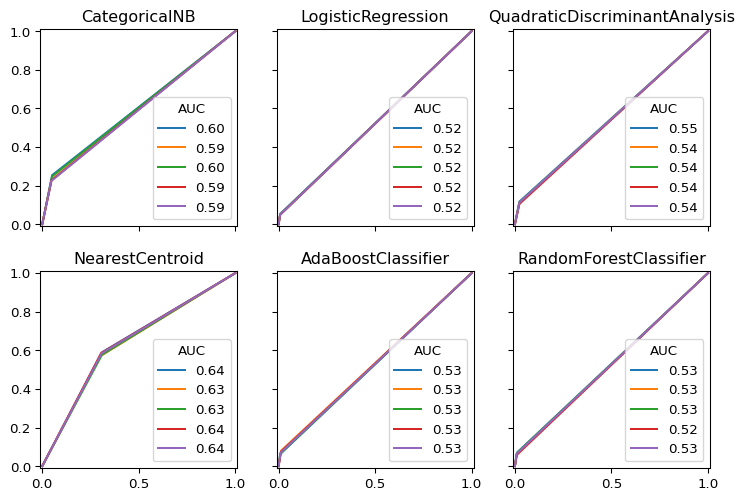

In [17]:
rf_df, rf_trained_models = train_and_predict_all_models(selected_class,df[['Smoker','BMI','PhysActivity','HighBP','HighChol']],y,folds=5)

In [18]:
rf_df.sort_values(by='avg F1',ascending=False)

,Name,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1,Elapsed
3,NearestCentroid,0.637399,0.638297,0.002811,0.234964,0.235029,0.001784,0.581112,0.584866,0.007507,0.334617,0.335279,0.002619,0.27 seconds
0,CategoricalNB,0.593809,0.591502,0.005148,0.438202,0.438474,0.004647,0.236717,0.230867,0.011912,0.307268,0.302474,0.011040,0.27 seconds
2,QuadraticDiscriminantAnalysis,0.544150,0.544290,0.002018,0.434447,0.433880,0.009722,0.111866,0.112463,0.004016,0.177910,0.178427,0.005851,0.29 seconds
4,AdaBoostClassifier,0.529809,0.529566,0.002326,0.516697,0.512980,0.024360,0.070418,0.069873,0.006566,0.123698,0.122993,0.009523,9.01 seconds
5,RandomForestClassifier,0.527268,0.527422,0.002016,0.510204,0.510858,0.014402,0.064562,0.064074,0.004342,0.114585,0.114307,0.007068,19.68 seconds
1,LogisticRegression,0.521024,0.520546,0.000880,0.493679,0.490780,0.009146,0.050416,0.049222,0.001803,0.091484,0.089541,0.003093,2.15 seconds


In [19]:
# Effectively all of the classifiers lose performance in every metric. Except for Nearest Centroid with improved AUC. But they all have lower F1 metric.
disp = 100*(rf_df.set_index('Name').drop('Elapsed',axis=1)-defaults_df.set_index('Name').drop('Elapsed',axis=1))/(defaults_df.set_index('Name').drop('Elapsed',axis=1))
disp.dropna()

,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1
Name,,,,,,,,,,,,
AdaBoostClassifier,-8.302343,-8.307705,130.298963,-4.009339,-4.655500,172.486176,-61.021857,-61.210286,184.278889,-54.270498,-54.430470,264.909613
CategoricalNB,-13.577018,-13.874101,369.247154,15.852579,15.923470,185.737076,-53.574510,-54.667379,266.622685,-29.249614,-30.234867,793.414003
LogisticRegression,-8.212909,-8.380893,-57.897115,-8.007812,-8.545590,-17.599964,-67.943650,-69.086794,-54.431174,-62.389866,-63.427964,-45.088024
NearestCentroid,-0.437466,-0.359543,45.002214,-15.016884,-15.192086,-31.084082,19.440241,19.816484,94.685465,-5.096260,-4.793524,2.284447
QuadraticDiscriminantAnalysis,-20.061575,-20.013946,-13.600325,37.530552,37.462504,497.286759,-79.899722,-79.811265,-24.539936,-55.855974,-55.742672,130.206689
RandomForestClassifier,-7.800140,-7.856281,68.853713,4.277467,4.127549,25.872787,-62.685811,-63.076456,64.471005,-55.169927,-55.502893,130.693228


While it is important to use clinically validated variables, we can't blindly *just* use them to build models at the expense of the information carried in the rest of the variables.

### 4.2: Feature selection, statistically significant features

To determine which features to keep. We will test which features in this dataset are statistically significantly associated with diabetes. There are 14 binary variables, for these ones we will use [Fisher's exact](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html) test to determine statistical significance. There are 7 features that are either ordinally-encoded categorical variables or discretized continuous variables, for these features we will use the [Mann-Whitney-Wilcoxon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) test.

In [20]:
def make_contingency_table(col,y):
    # cont_table =pd.DataFrame(columns=[col.name,'Diabetes'])
    # cont_table[col.name] = col.values
    vals = col.values
    # cont_table['Diabetes'] = y
    diabetes = y.values
    return pd.crosstab(vals,diabetes,rownames=[col.name],colnames=['Diabetes'])

# make_contingency_table(df[col],y)

Binary:HighBP,5.03754684872288, pval=0, Significant
Binary:HighChol,3.2546051009457626, pval=0, Significant
Binary:CholCheck,6.428981310487366, pval=0, Significant
Categorical: BMI,64353542400.0, pval=0, Significant
Categorical: BMI,14715.988202162389, pval=0, Significant
Binary:Smoker,1.4199314527613334, pval=1.4e-204, Significant
Binary:Stroke,3.0648576767818647, pval=0, Significant
Binary:HeartDiseaseorAttack,3.6232530337234357, pval=0, Significant
Binary:PhysActivity,0.48996970391001626, pval=0, Significant
Binary:Fruits,0.7869473405868949, pval=1.8e-92, Significant
Binary:Veggies,0.6801313733102077, pval=4.2e-169, Significant
Binary:HvyAlcoholConsump,0.3679673129136659, pval=8.1e-222, Significant
Binary:AnyHealthcare,1.2650907847913229, pval=5.4e-17, Significant
Binary:NoDocbcCost,1.34942275380753, pval=2.7e-53, Significant
Categorical: GenHlth,63552973173.0, pval=0, Significant
Categorical: GenHlth,22728.069055166736, pval=0, Significant
Categorical: MentHlth,38814606486.0, pval=

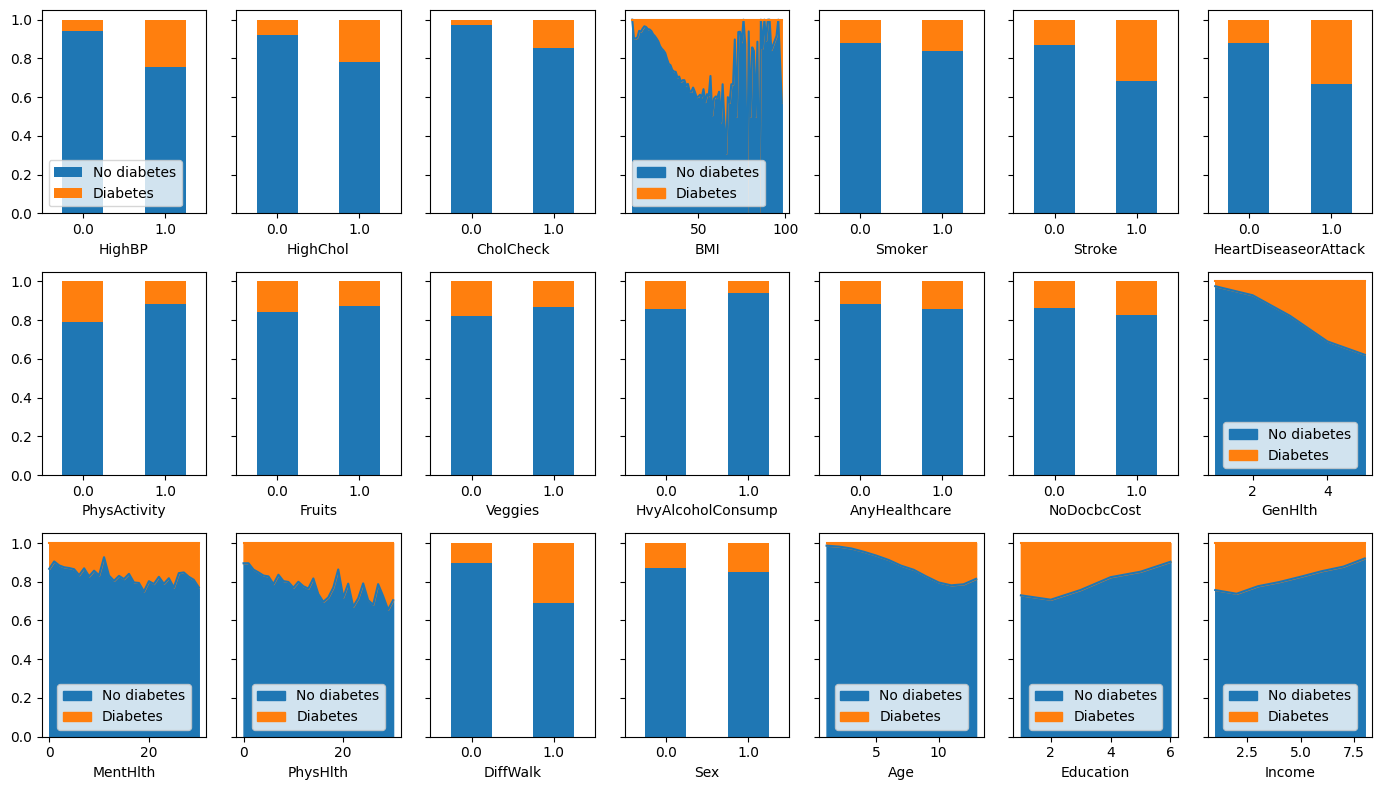

In [21]:
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(14, 8),sharey=True)
# Flatten the axes array (makes it easier to iterate over)
axes = axes.flatten()

i=0
alpha=0.05
binary = 0
for col in df.columns:
    cont_table = make_contingency_table(df[col],y)
    no_diabetes = cont_table[0]
    diabetes = cont_table[1]
    index = cont_table.index
    new_plot = pd.DataFrame({'No diabetes': no_diabetes,'Diabetes': diabetes}, index=index)
    
    if len(df[col].unique())==2: #Binary variables
        binary+=1
        res = fisher_exact(cont_table, alternative='two-sided')
        # res = chi2_contingency(make_contingency_table(df[col],y),lambda_="log-likelihood")
        if res.pvalue<=alpha: significant='Significant' 
        else: significant= "Not significant"
        print(f"Binary:{col},{res.statistic}, pval={res.pvalue:.2g}, {significant}")
        
        #make plot
        
        ax = new_plot.apply(lambda row: row/row.sum(),axis=1).plot.bar(rot=0,stacked=True,ax=axes[i])
        if i==0:
            ax.legend(loc=3)
        else:
            ax.legend().remove()
            # axes[i].get_legend().remove()
    else:
        #Categorical variables
        U1, p = mannwhitneyu(df[col],y, method='asymptotic')
        res = chi2_contingency(make_contingency_table(df[col],y))
        if p<=alpha: significant='Significant' 
        else: significant= "Not significant"
        print(f"Categorical: {col},{U1}, pval={p:.2g}, {significant}")
        print(f"Categorical: {col},{res.statistic}, pval={res.pvalue:.2g}, {significant}")
        ax = new_plot.apply(lambda row: row/row.sum(),axis=1).plot.area(rot=0,stacked=True,ax=axes[i])
    i+=1
plt.tight_layout()
print(f'There were {binary} variables and {len(df.columns)-binary} non-binary ones.')


Quite a few of the categorical/ordinal variables are not smooth, due to them having few elements for some values. For example BMI. This is something we could explictly handle, turning these into binary indicators: e.g. BMI>25. However the classifiers we have selected do those kinds of variable conversions internally. So this step will be left for future improvements.

In [22]:
# # col='BMI'
# # cont_table = make_contingency_table()
# # no_diabetes = cont_table[0]
# # diabetes = cont_table[1]
# # index = cont_table.index
# # new_plot = pd.DataFrame({'No diabetes': no_diabetes,'Diabetes': diabetes}, index=index)
# # new_plot

# new_plot = pd.DataFrame(columns=[col,'Diabetes'])
# new_plot[col] = df[col]
# new_plot['Diabetes'] = y
# new_plot['Diabetes'] = new_plot['Diabetes'].replace(1,'Diabetes')
# new_plot['Diabetes'] = new_plot['Diabetes'].replace(0,'No diabetes')
# sns.histplot(data=new_plot,hue='Diabetes',x=col,stat='proportion',multiple='stack',hue_order=['No diabetes','Diabetes'],bins=50)

We will try Recursive feature elimination with cross-validation

More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

In [23]:
from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider
#Logistic regression is commonly used for this
clf = all_class['LogisticRegression'] #we have already loaded this
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="f1", #as discussed above
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 21


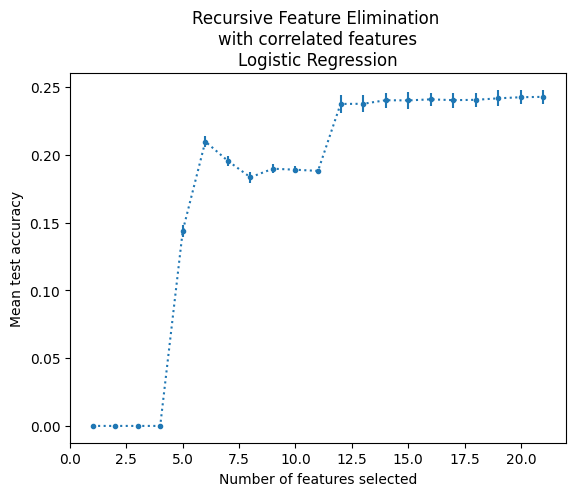

In [24]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(x=cv_results["n_features"], y=cv_results["mean_test_score"], yerr=cv_results["std_test_score"],linestyle=':',marker='.')
plt.title("Recursive Feature Elimination \nwith correlated features\nLogistic Regression")
plt.show()

So, even though this has only been done with Logistic Regression and other models can be used. We will conclude that using all 21 features is the way to go.

### 4.3: Hyperparameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV, KFold
# selected_class

In [12]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [52]:
def gridsearch(classifier,param_grid,estimator_name,ax=None):
  gridsearch_cv = KFold(n_splits=5, shuffle=True, random_state=42)

  clf = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=gridsearch_cv,scoring='f1',refit=True)
  clf.fit(X_train, y_train)
  # clf.best_score_
  # gs_df =  pd.DataFrame(clf.cv_results_)
  gs_df =  pd.DataFrame(clf.cv_results_)
  # gs2plot = gs_df[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']].T
  gs2plot = gs_df[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']].dropna().T
  if ax is None:
    ax = sns.barplot(data=gs2plot,errorbar='sd',color='#1f77b4')
  else:
    ax = sns.barplot(data=gs2plot,errorbar='sd',color='#1f77b4',ax=ax)
  # ax.patches[clf.best_index_].set_facecolor('#ff7f0e')
  custom_best_ix = gs2plot.T.dropna().T.mean().rank().reset_index(drop=True).idxmax()
  ax.patches[custom_best_ix].set_facecolor('#ff7f0e')
  # ax.patches[gs_df[gs_df['rank_test_score']==1].index[0]].set_facecolor('#ff7f0e')
  ax.set_xlabel('Parameter Combination Iteration Number')
  ax.set_ylabel('F1 Score +/- std')
  ax.set_title(f"{estimator_name} Hyperparameter tuning\nHiglighed: Results From Best Parameters")
  print(f'{estimator_name}|Best score:{clf.best_score_:.3f}|Best parameters:{clf.best_params_}')
  return clf.best_estimator_,clf


CategoricalNB|Best score:0.437|Best parameters:{'alpha': 5, 'fit_prior': False, 'min_categories': None}


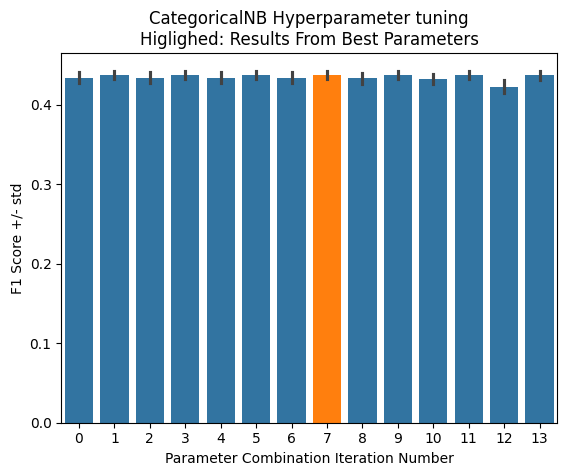

In [ ]:
estimator_name = 'CategoricalNB'
param_grid = [
  {'alpha': [0, 0.5, 1, 5,10,15, 100],
  'fit_prior': [True,False],
  'min_categories':[None]}, #We have to set this as None given our type of data
  ]
best_nb_estimator,nb_clf = gridsearch(classifier=selected_class[estimator_name],param_grid=param_grid,estimator_name=estimator_name)

In [54]:
# gs_df =  pd.DataFrame(clf.cv_results_)

c:\Users\ejuarezrosales\OneDrive - rchsd.org\Documents\Projects\diabetes\DiabetesMLPredictor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.24154201 0.24152158        nan 0.20170376 0.20170815        nan
 0.44323663 0.44321169        nan 0.4222831  0.42226454        nan]
  warnings.warn(


LogisticRegression|Best score:0.443|Best parameters:{'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


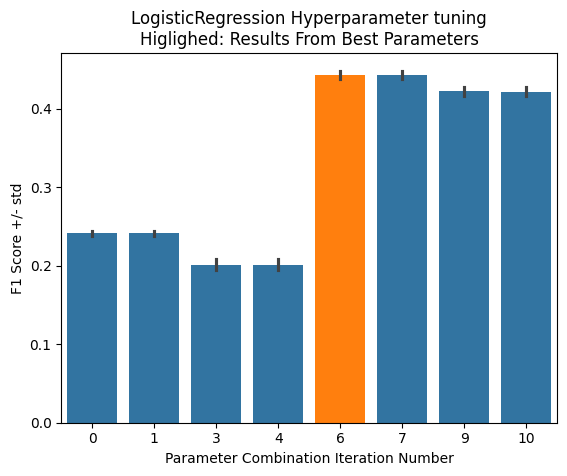

In [56]:
estimator_name = 'LogisticRegression'
param_grid = [
  {'penalty': ['l2','l1','elasticnet'],
   'solver':['liblinear'], #Only this solver will work here 
   'fit_intercept': [True,False],
   'class_weight':[None, 'balanced']
  },
  ]
best_lr_estimator,lr_clf = gridsearch(classifier=selected_class[estimator_name],param_grid=param_grid,estimator_name=estimator_name)
# gs_df =  pd.DataFrame(clf.cv_results_)

QuadraticDiscriminantAnalysis|Best score:0.40|Best parameters:{'reg_param': 0}


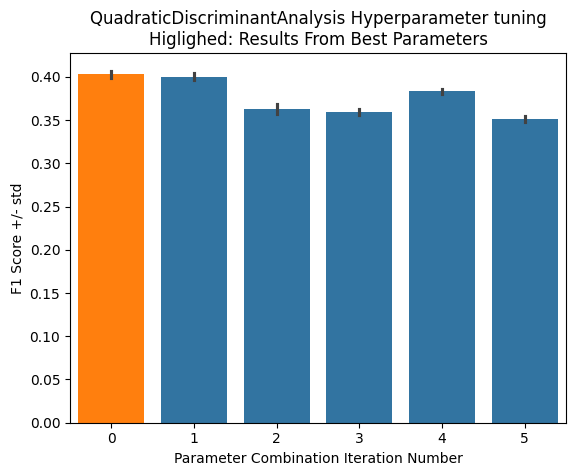

In [ ]:
estimator_name = 'QuadraticDiscriminantAnalysis'
param_grid = [
  {'reg_param': [0,0.01,0.1,0.5,0.75,1],
   },
  ]
best_qda_estimator,qda_clf = gridsearch(classifier=selected_class[estimator_name],param_grid=param_grid,estimator_name=estimator_name)

NearestCentroid|Best score:0.42|Best parameters:{'metric': 'euclidean', 'priors': 'empirical', 'shrink_threshold': None}


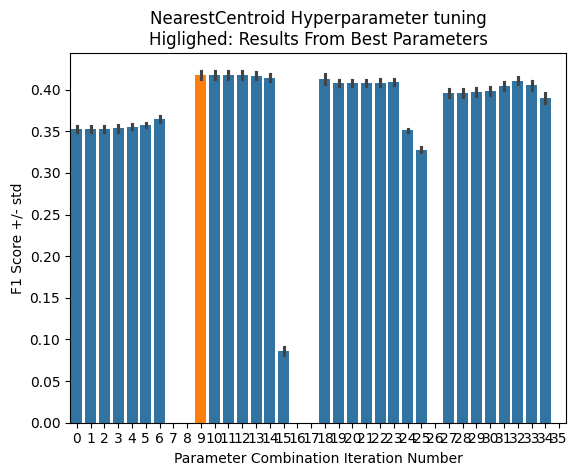

In [ ]:
estimator_name = 'NearestCentroid'
param_grid = [
  {'metric': ['euclidean','manhattan'],
   'shrink_threshold': [None,0.1,0.5,1,5,10,50,100,500],
   'priors':['uniform', 'empirical']
   },
  ]
best_nc_estimator,nc_clf = gridsearch(classifier=selected_class[estimator_name],param_grid=param_grid,estimator_name=estimator_name)

c:\Users\ejuarezrosales\OneDrive - rchsd.org\Documents\Projects\diabetes\DiabetesMLPredictor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.20218179 0.28056073
 0.28468796 0.27973752 0.2445836  0.         0.         0.        ]
  warnings.warn(


AdaBoostClassifier|Best score:0.28|Best parameters:{'learning_rate': 1, 'n_estimators': 100}


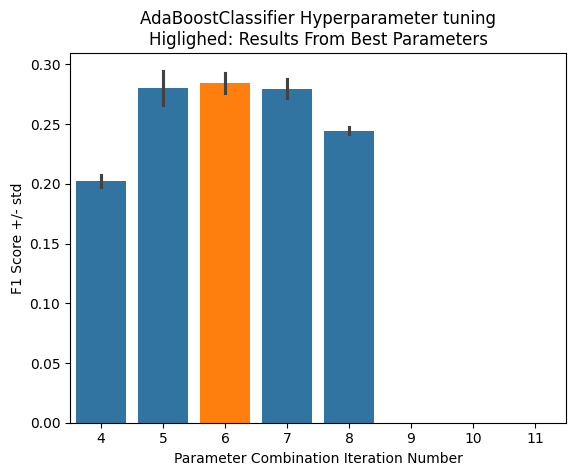

In [ ]:
estimator_name = 'AdaBoostClassifier'#we'll keep the stumps as the estimator
param_grid = [
  {'n_estimators': [10,50,100,500],
   'learning_rate': [0,1,10],
   },
  ]
best_ab_estimator,ab_clf = gridsearch(classifier=selected_class[estimator_name],param_grid=param_grid,estimator_name=estimator_name)

RandomForestClassifier|Best score:0.26|Best parameters:{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 50}


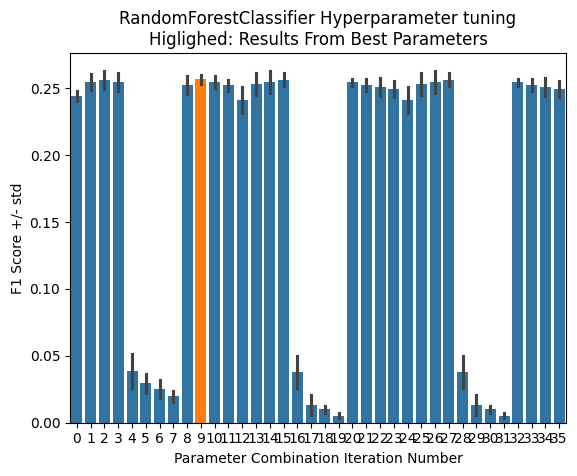

In [ ]:
estimator_name = 'RandomForestClassifier'
param_grid = [
  {'n_estimators': [10,50,100,500],
   'criterion': ['gini','entropy','log_loss'],
   'max_depth':[None,5,25],
   #There are more parameters to optimize, but each run is computationally expensive. Consider running this on a cluster.
   },
  ]
best_rf_estimator,rf_clf = gridsearch(classifier=selected_class[estimator_name],param_grid=param_grid,estimator_name=estimator_name)

After hyperparameter tuning, the best estimator is the l2-Logistic regression:

In [58]:
best_lr_estimator

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

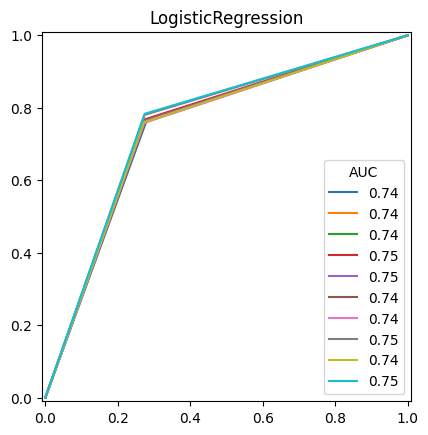

In [ ]:
#doing 10-fold crossvalidation on the best overall model
model,y_pred,auc_scores,precision_scores,recall_scores,f1_scores = train_and_predict(X_train,y_train,best_lr_estimator,X_test=None,y_test=None,folds=10,make_ROC_plots=True,ax=None)

## Step 5: Model Validation and Results Interpretation

In [101]:
# # best_lr_estimator.predict()
# y_pred = best_lr_estimator.predict(X_val)
# # # y_probs = model.predict_proba(X_test)
# cm = confusion_matrix(y_val, y_pred)
# tn, fp, fn, tp = cm.ravel()
# display(np.array([['tn','fp'],['fn', 'tp']]))
# display(cm)
# # print(tn, fp, fn, tp)

# fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred, pos_label=1)
# auc = metrics.auc(fpr, tpr)

# p,r,f,_ = precision_recall_fscore_support(y_val,y_pred,average='binary',pos_label=1)

# print(auc,p,r,f)

F1=0.44|Recall=0.76|Precision=0.31|AUC=0.74


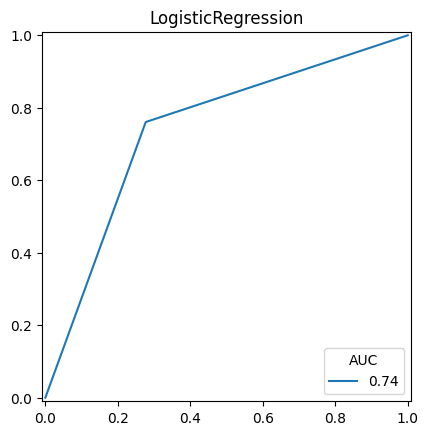

In [99]:
model,y_pred,auc_score,precision_score,recall_score,f1_score = train_and_predict(X_train,y_train,best_lr_estimator,X_test=X_val,y_test=y_val,folds=1,make_ROC_plots=True,ax=None)
print(f'F1={f1_score:.2f}|Recall={recall_score:.2f}|Precision={precision_score:.2f}|AUC={auc_score:.2f}')

In [130]:
X_val.to_csv('formatted_data/X_val.csv')

In [132]:
y_val.to_csv('formatted_data/y_val.csv')

In [134]:
import pickle
with open('formatted_data/best_lr_estimator.pkl', 'wb') as f: 
    pickle.dump(best_lr_estimator, f)

# # Getting back the objects:
# with open('formatted_data/best_lr_estimator.pkl','rb') as f:  
#     best_lr_estimator = pickle.load(f)

In [128]:
y_pred = best_lr_estimator.predict(X_val)
y_probs = model.predict_proba(X_val)
cm = confusion_matrix(y_val, y_pred)
print("confusion matrix as a pecert of the total population")
cm_df = pd.DataFrame(cm)
display(cm_df)
display((100*cm_df/len(y_val)).round(2))
display(pd.DataFrame([['True Negative','False Positive'],['False Negative', 'True Positive']]))

confusion matrix as a pecert of the total population


,0,1
0,15784,6049
1,846,2689


,0,1
0,62.22,23.85
1,3.33,10.60


,0,1
0,True Negative,False Positive
1,False Negative,True Positive


In [127]:
print('Row-normalizing the confusion matrix:')
100*cm_df.div(cm_df.sum(axis=1), axis=0).round(3)

Row-normalizing the confusion matrix:


,0,1
0,72.3,27.7
1,23.9,76.1


This means that the model identifies:
- 76% of the patients who have diabetes
- 72% Of the patients who don't have diabetes  

These are good results.

However the model also incorrectly preditc that ~28% of patients to have diabetes when they do not in fact have diabetes. And It misses ~24% of patients who do have diabetes.

The real-world penalties for these two groups are important to consider. While it is acceptable that some patients would be unnecesarily sent for extra diagnostic tests to discard the possibility of diabetes, ideally the tradeoff should be much lower false negatives.

So this model should be further optimized by looking more carfully at the feature preprocessing.

Let's take a look at the missclasified population:

In [151]:
val = pd.DataFrame()
val['Diagnosis'] = y_val
val['Predictions'] = y_pred
fn_list = list(val[(val['Diagnosis']==1)&(val['Predictions']==0)].index)
tn_list = list(val[(val['Diagnosis']==0)&(val['Predictions']==0)].index)
fp_list = list(val[(val['Diagnosis']==0)&(val['Predictions']==1)].index)
tp_list = list(val[(val['Diagnosis']==1)&(val['Predictions']==1)].index)


(3535, 22)

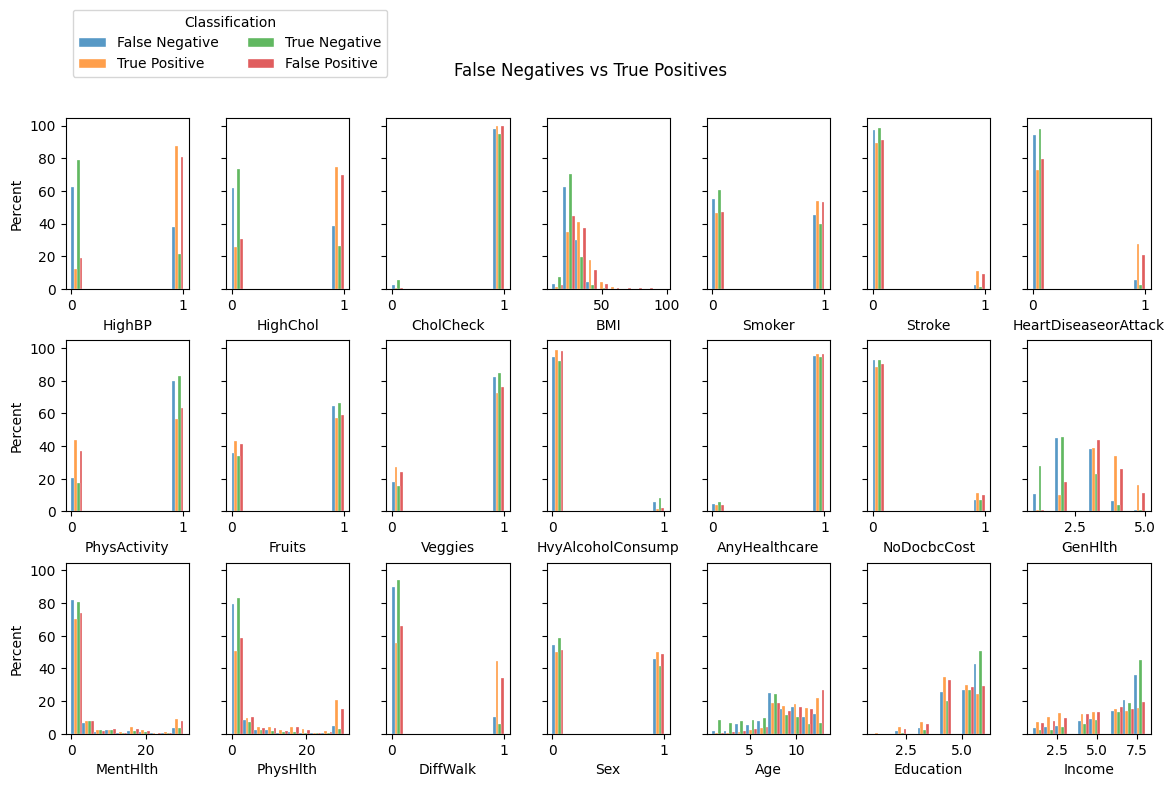

In [196]:
to_plot_1 = X_val.loc[fn_list]
to_plot_1['Classification'] = 'False Negative'
to_plot_2 = X_val.loc[tp_list]
to_plot_2['Classification'] = 'True Positive'
to_plot_3 = X_val.loc[tn_list]
to_plot_3['Classification'] = 'True Negative'
to_plot_4 = X_val.loc[fp_list]
to_plot_4['Classification'] = 'False Positive'
to_plot = pd.concat([to_plot_1,to_plot_2,to_plot_3,to_plot_4])
plot_histograms(to_plot=to_plot,title='False Negatives vs True Positives',col='Classification',tight=False)

Note hwo the cool colors (FN & TN) *seem* like they belong to the same distribution, same can be said for the hot colors (TP & FP)

TO DO:
- Look at feature importance for Logistic Regression
- Distribution per column, compute earthmover's distance --> Show that FP is closer to TP than TN, show that FN is closer to TN than TP
- Compute the statistical significance of FNvsTN and TPvsFP
- Look at y_proba to see if the FP & FN are close to borderline

## Step 6: Model Deployment

Future directions:
- Can these 21 variables be automatically extracted from patient's EMRs?
- Can these results be enhanced by adding data from the patient's EMRs? E.g.,  specialty vistis, lab results, family history, PCP appointment frequency and notes
- Because these 21 variables/features can be easily turned into a questionaire, either paper-based or app-based, to provide to patients at PCP clinics.
- Further develop the predictive capabilities of this model to provide a qualitative risk score for individual patients, so upon questionaire completion they and their medical team can decide how high of a priority it is to look into Diabetes or Pre-diabetes diagnoses

In [ ]:
#Note: to export this notebook as a PD, run: `jupyter nbconvert --to webpdf NAME_OF_NB.ipynb` in the terminal.